# Präsenzversuch zum Laval-Rotor

Name:  Santiago Ramirez Saldana
Datum:  05.02.2024
Gruppe: 37

## Forschungsfrage

Formulieren Sie eine oder mehrere Forschungsfragen zu der Lerneinheit:
Wie lassen sich Eigenfrequenzen berechnen und wie können sie grafisch dargestellt werden? 

## Erster Versuch: Prüfstand #04
Hier werden Sie die Messergebnisse des ersten Prüfstands auswerten. Die Auswertung des zweiten Prüfstands kann analog erfolgen, die entsprechenden jupyter-notebook-Zellen sind weiter unten vorbereitet.
Bitte ergänzen Sie im Titel der Markdown-Zellen die Nummer des Prüfstands

###  Versuchsaufbau
- Bild des Prüfstands:

<img src="figures/Bild.jpg" width="800">

- Beschreibung des Aufbaus, gehen Sie auf die Anzahl der Scheiben und deren Gewicht ein:

Das Experiment besteht aus einer Welle, die etwa 0,75 m lang ist und einen Durchmesser von etwa 8 mm hat. In der Mitte der Welle befindet sich eine Scheibe mit einem Gewicht von 1 kg, einem Durchmesser von 99 mm und einer Breite von 15 mm. Zur Lagerung der Welle werden an jedem Ende zwei Pendelkugellager verwendet. Um die Beschleunigung der Welle in verschiedene Richtungen zu messen, wird an einem Ende ein Beschleunigungssensor eingesetzt.
Aus Sicherheitsgründen ist das ganze System in einem Container untergebracht.

### Versuchsauswertung

In [1]:
import os
import h5py
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import importlib
import json

from functions import m_postprocessing

path = os.path.join("supplementary_code", "FST.mplstyle")
plt.style.use(path)

#### 1. Einlesen der Mess- und Metadaten

Beim Einlesen der Mess- und Metadaten geben wir Ihnen bereits eine Struktur vor. Es bietet sich an diese zu verwenden, ist aber nicht zwingend erforderlich.

##### 1.a) Angabe der Pfade und Dateinamen
Passen Sie die unten stehenden Pfade an, indem Sie `None` ersetzen.

In [2]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240115_141438_lavalrotor_37_04"
)
filename = "data_20240115_141438_lavalrotor_37_04.h5"  
h5_path=os.path.join(path_measurement_folder,filename) 

##### 1.b) Preparieren der Metadaten
Wenn Sie die Pfade oben korrekt definiert haben, dann müssen Sie hier nichts anpassen. Schauen Sie sich die Struktur von `setup_dict` an und die zurückgegebenen IDs `uuid_acceleration` und `uuid_motor_rpm`.

In [3]:
setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

uuid_acc, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240115_141438_lavalrotor_37_04/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823ce-82b9-6d4e-a621-60af4e6f5cc1": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240115_141438_lavalrotor_37_04/1ee823ce-82b9-6d4e-a621-60af4e6f5cc1.json"
  },
  "1ee823b6-50dc-6670-aea5-35f6dd717e83": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240115_141438_lavalrotor_37_04/1ee823b6-50dc-6670-aea5-35f6dd717e83.json"
  },
  "1ee8239b-46ec-63dc-8aa4-b8751ac37fd3": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240115_141438_lavalrotor_37_04/1ee8239b-46ec-63dc-8aa4-b8751ac37fd3.json"
  },
  "1ee823d6-3d20-6332-83f5-6876b760dcf3": {
    "type": "sensor",
  

##### 1.c) Initialisieren der Datenstrukturen für die Messdaten
Hier wird der Vektor `interpolation_points` mit Stützstellen für die Interplation der Messdaten für alle Drehzahlen erzeugt. Dieses vereinfacht später die Darstellung des Campbell-Diagramms enorm.

Initialisieren Sie Datenstrukturen um alle nötigen Daten für das Campbell-Diragramm abspeichern zu können, verwenden Sie dazu ggf. `interpolation_points`.

In [4]:
measurement_time_in_s = 10
number_interpolation_points = 2000

inter_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)


file = h5py.File(os.path.join(path_measurement_folder, filename), "r")


acc_x = []
acc_y = []
acc_z = [] 
time = [] 
rpm = [] 


for i in range(len(file.keys())):

    for key in file.keys():
        if str(i) == key:

            acc_x.append(np.array(file[key]["RawData"][uuid_acc]["acceleration_x"]))
            acc_y.append(np.array(file[key]["RawData"][uuid_acc]["acceleration_y"]))
            acc_z.append(np.array(file[key]["RawData"][uuid_acc]["acceleration_z"]))
            time.append(np.array(file[key]["RawData"][uuid_acc]["timestamp"]))
            rpm.append(np.array(file[key]["RawData"][uuid_motor_rpm]["motor_rpm"]))

#### 2. Verarbeitung der Messdaten

Verarbeiten Sie die Messdaten für alle untersuchten Drehzahlen mit `m_postprocessing.get_vec_accel()`, `m_postprocessing.interpolation()` und `m_postprocessing.my_fft_scaled()`.

In [5]:
importlib.reload(m_postprocessing)  


abs_acc = []
interp_data = []
fft_res = []
for i in range(len(acc_x)):
    abs_acc.append(m_postprocessing.get_vec_accel(acc_x[i], acc_y[i], acc_z[i]))
    interp_data.append(m_postprocessing.interpolation(time[i], abs_acc[i], inter_points))
    fft_res.append(m_postprocessing.my_fft_scaled(interp_data[i], inter_points))
freq_ex = fft_res[0][1]
amp_res = []

for i in fft_res:
    amp_res.append(i[0])
    
amp_res = np.array(amp_res)
amp_res = np.transpose(amp_res)

#### 3. Darstellung mittels Campbell-Diagramm

Erzeugen Sie hier ein Campbell-Diagramm aus den Messdaten.

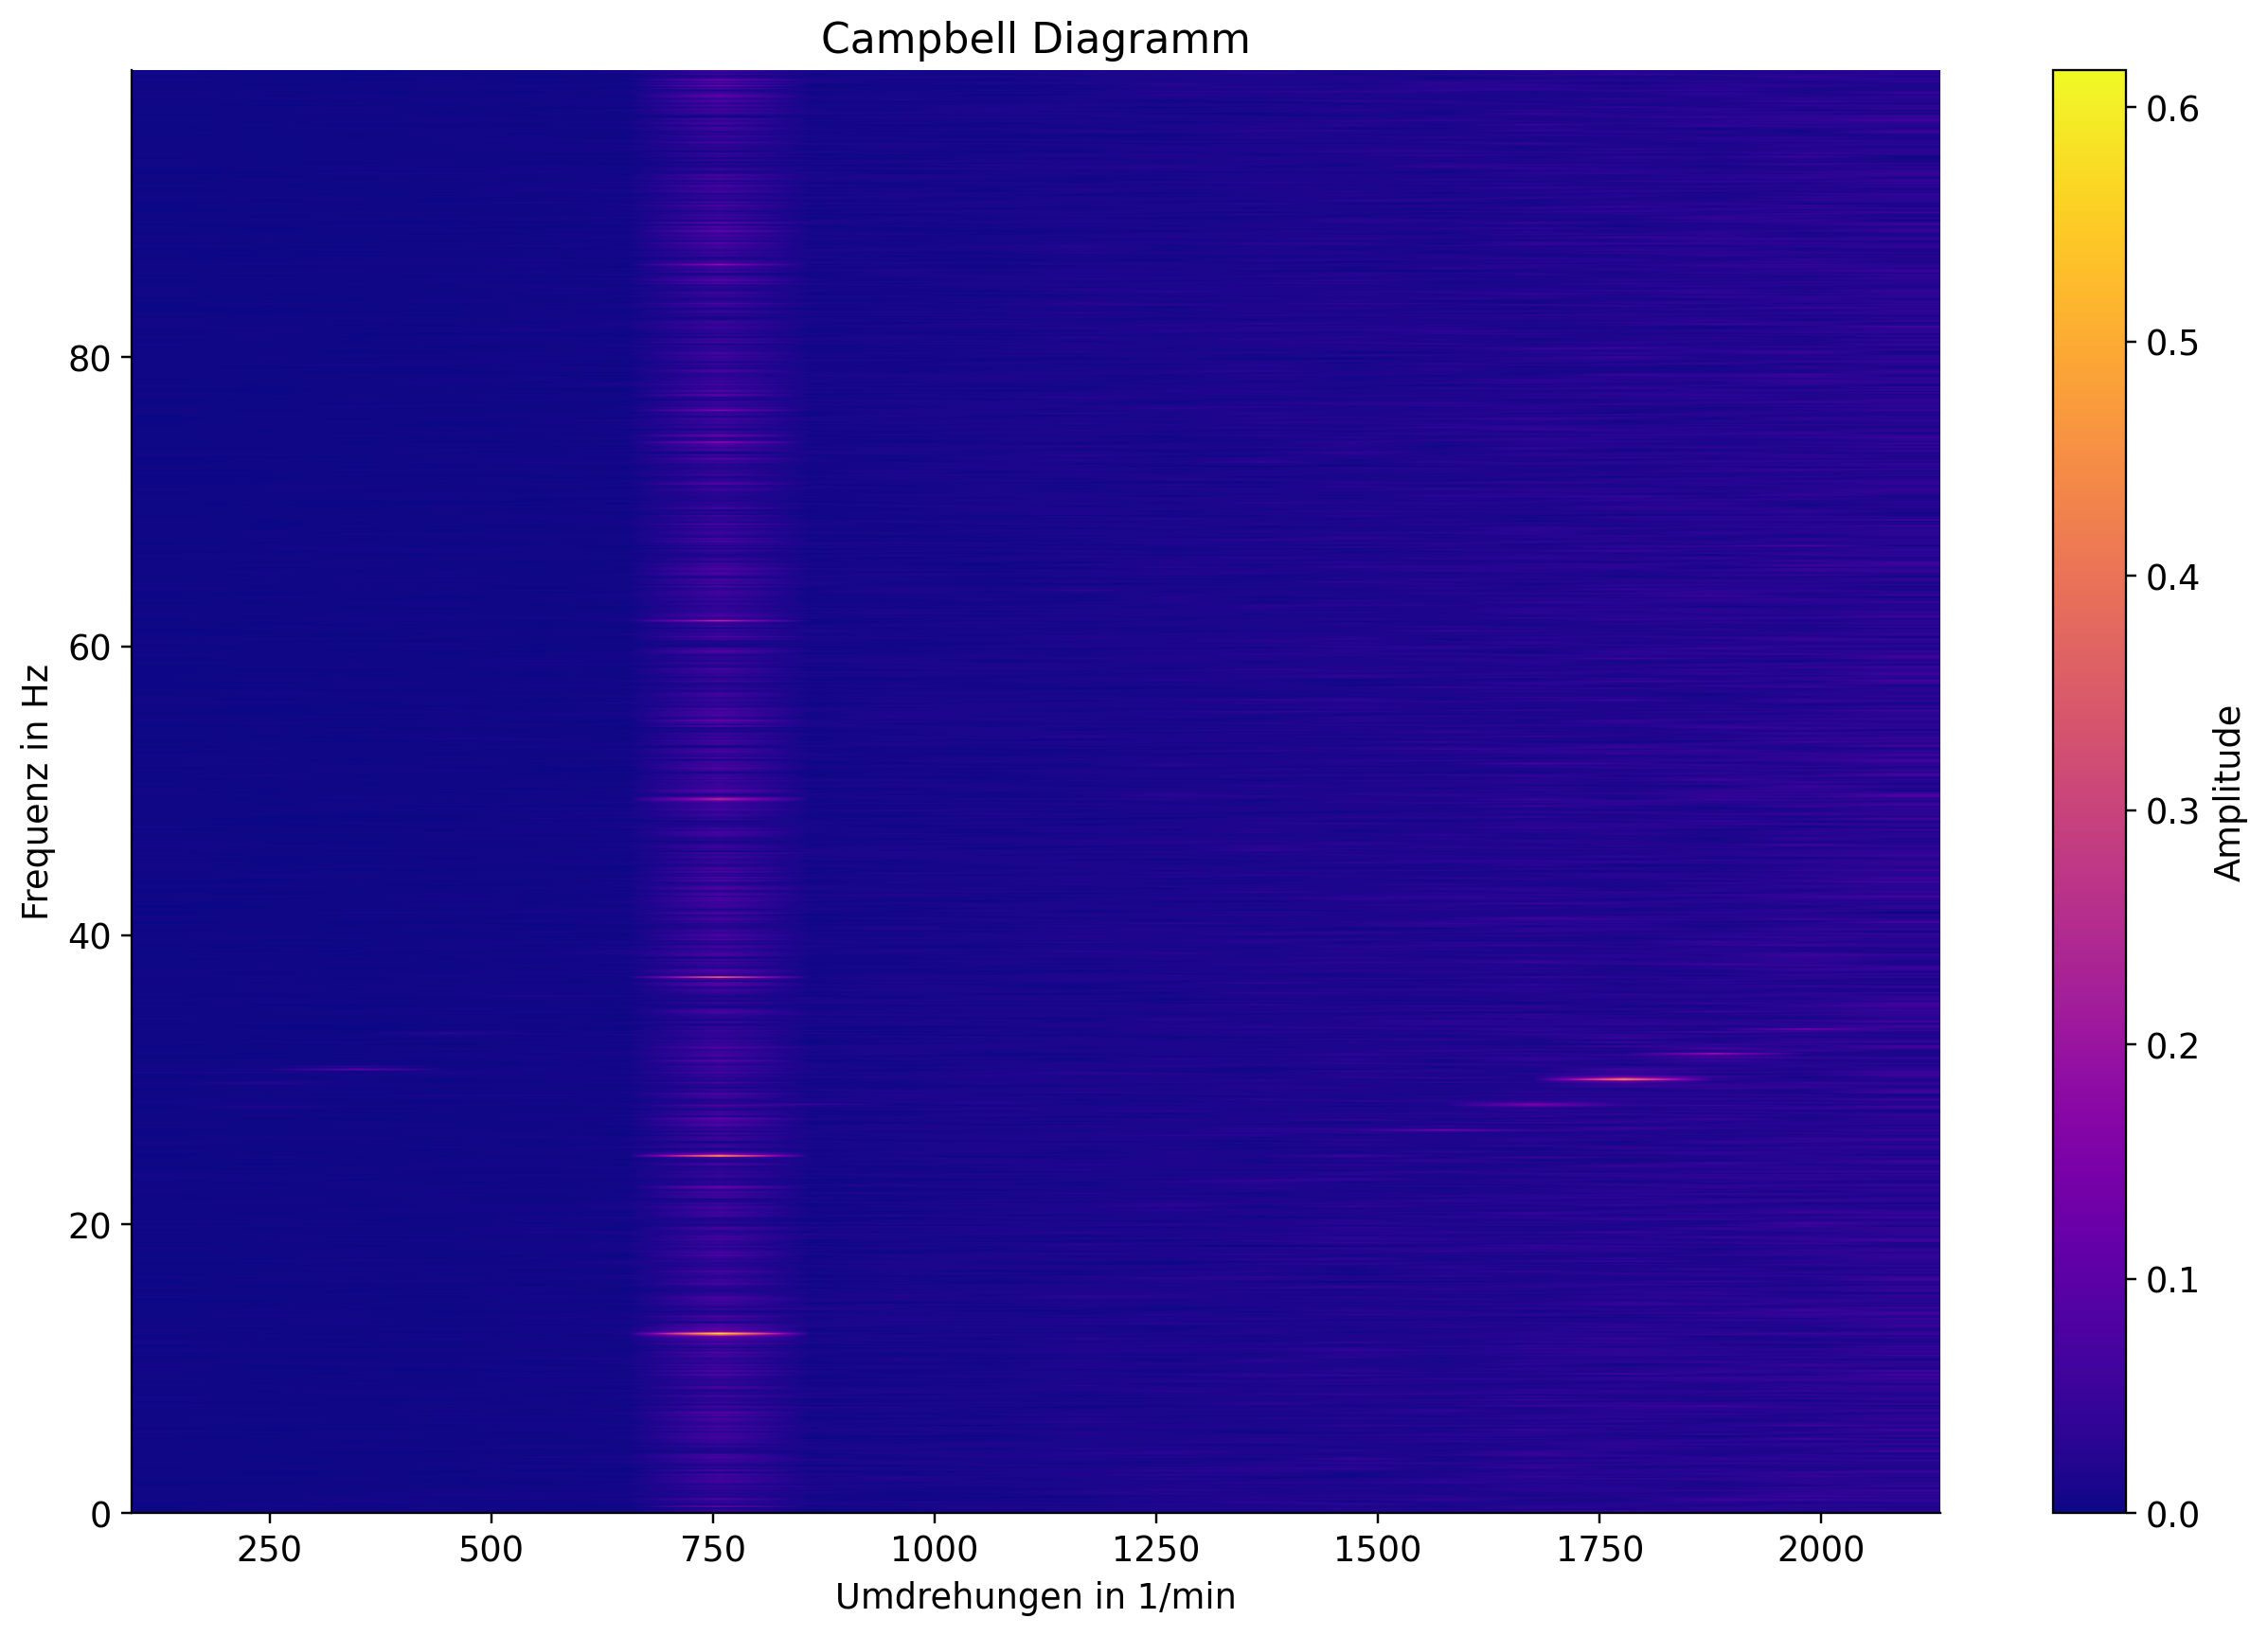

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 9))  

plt.imshow(amp_res, 
           extent=[min(rpm), 
                   max(rpm), 0, 
                   max(freq_ex)],  
           aspect="auto",  
           interpolation="bilinear",
           cmap="plasma",
           origin="lower"  
          )

plt.xlabel("Umdrehungen in 1/min")
plt.ylabel("Frequenz in Hz") 
plt.colorbar(label="Amplitude")
plt.title("Campbell Diagramm")
plt.show()

## Zweiter Datensatz: Prüfstand #02

#### 1. Einlesen der Mess- und Metadaten

In [7]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240102_100928_lavalrotor_01_02"
)  
filename = "data_20240102_100928_lavalrotor_01_02.h5"  
h5_path=os.path.join(path_measurement_folder,filename)

setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))
uuid_acc, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

measurement_time_in_s = 10
number_interpolation_points = 2000
inter_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)  



file = h5py.File(os.path.join(path_measurement_folder, filename), "r")


acc_x = []
acc_y = []
acc_z = [] 
time = [] 
rpm = [] 


for i in range(len(file.keys())):

    for key in file.keys():
        if str(i) == key:

            acc_x.append(np.array(file[key]["RawData"][uuid_acc]["acceleration_x"]))
            acc_y.append(np.array(file[key]["RawData"][uuid_acc]["acceleration_y"]))
            acc_z.append(np.array(file[key]["RawData"][uuid_acc]["acceleration_z"]))
            time.append(np.array(file[key]["RawData"][uuid_acc]["timestamp"]))
            rpm.append(np.array(file[key]["RawData"][uuid_motor_rpm]["motor_rpm"]))

{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823cc-06c7-631a-99e2-dc18593ae07a": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee823cc-06c7-631a-99e2-dc18593ae07a.json"
  },
  "1ee823b3-32d9-6d20-8261-106b0e021eed": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee823b3-32d9-6d20-8261-106b0e021eed.json"
  },
  "1ee82398-0056-698f-8809-248cede81c54": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee82398-0056-698f-8809-248cede81c54.json"
  },
  "1ee823d3-8511-6a0b-8cd5-972f083673c9": {
    "type": "sensor",
  

#### 2. Verarbeitung der Messdaten

In [8]:
importlib.reload(m_postprocessing)  

abs_acc = []
interp_data = []
fft_res = []
for i in range(len(acc_x)):
    abs_acc.append(m_postprocessing.get_vec_accel(acc_x[i], acc_y[i], acc_z[i]))
    interp_data.append(m_postprocessing.interpolation(time[i], abs_acc[i], inter_points))
    fft_res.append(m_postprocessing.my_fft_scaled(interp_data[i], inter_points))
freq_ex = fft_res[0][1]

amp_res = []

for i in fft_res:
    amp_res.append(i[0])
    

amp_res = np.array(amp_res)
amp_res = np.transpose(amp_res)

#### 3. Darstellung mittels Campbell-Diagramm

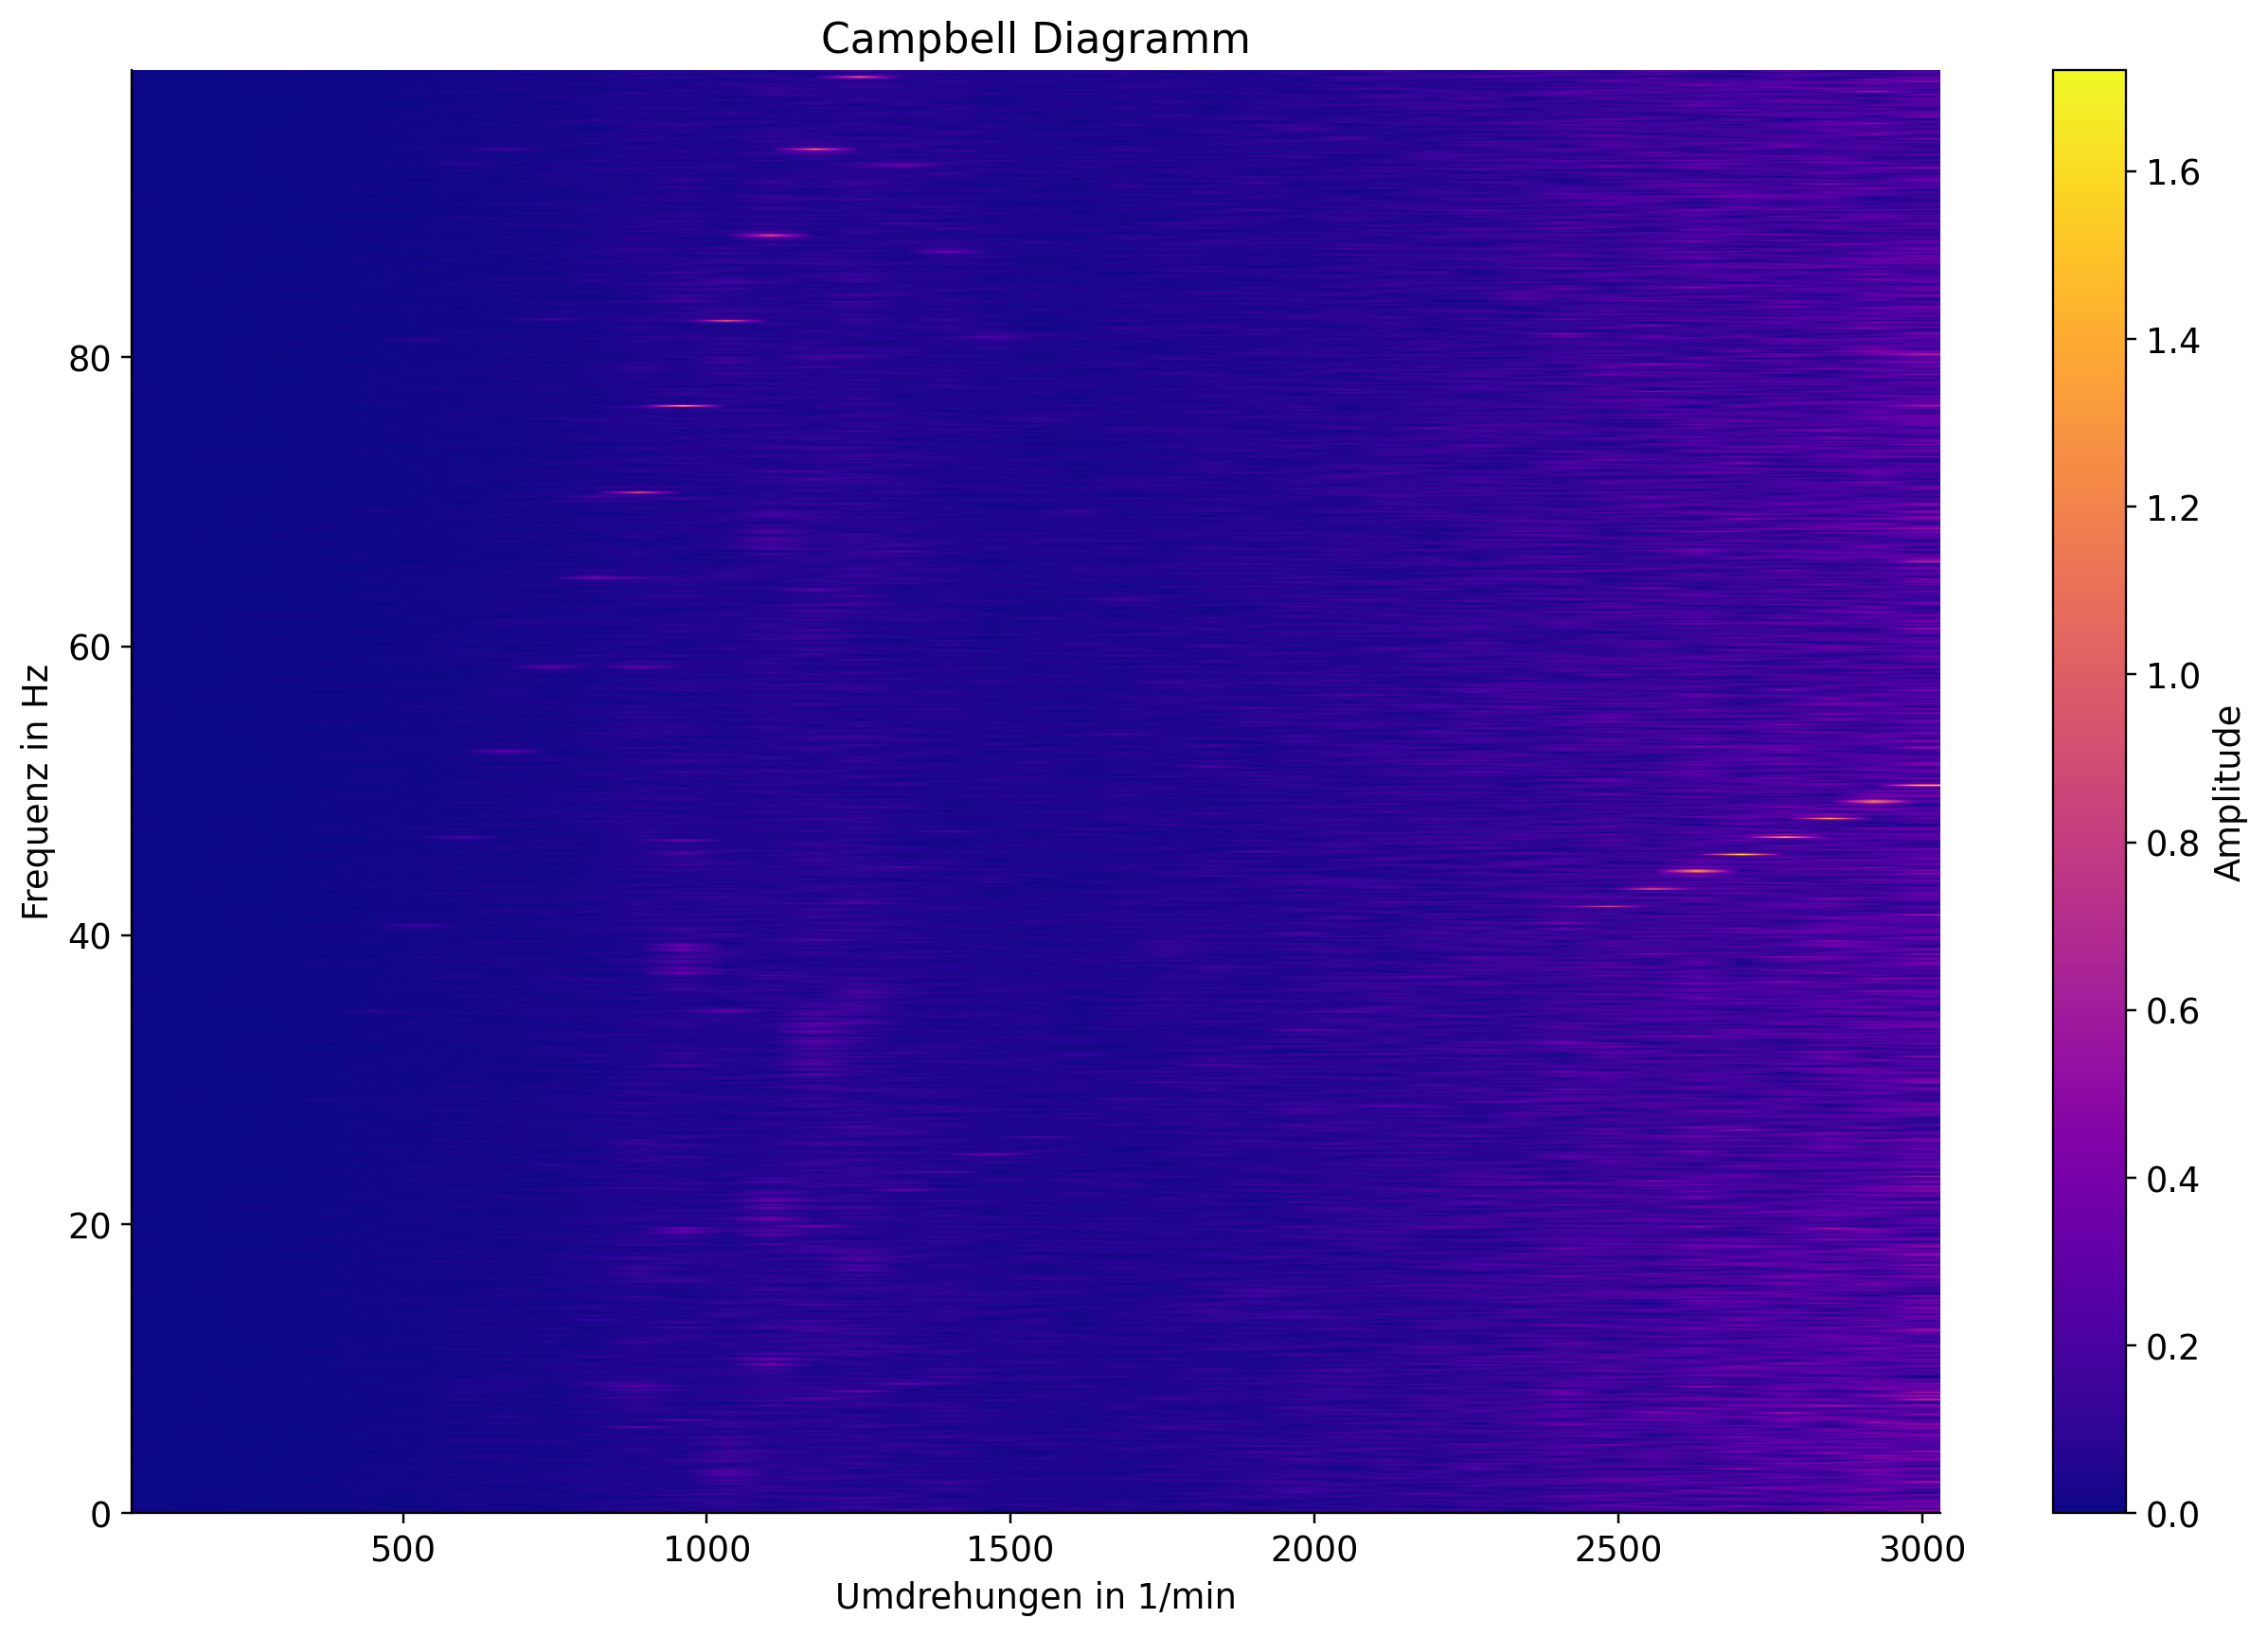

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 9))  
plt.imshow(amp_res, 
           extent=[min(rpm), 
                   max(rpm), 0, 
                   max(freq_ex)],  
           aspect="auto",  
           interpolation="bilinear",
           cmap="plasma",
           origin="lower"  
          )

plt.xlabel("Umdrehungen in 1/min")
plt.ylabel("Frequenz in Hz") 
plt.colorbar(label="Amplitude")
plt.title("Campbell Diagramm")
plt.show()

## Dritter Datensatz: Prüfstand #03

#### 1. Einlesen der Mess- und Metadaten

In [10]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240102_112539_lavalrotor_01_03"
)  
filename = "data_20240102_112539_lavalrotor_01_03.h5"  
h5_path=os.path.join(path_measurement_folder,filename)

setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))
uuid_acc, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

measurement_time_in_s = 10
number_interpolation_points = 2000
inter_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)

file = h5py.File(os.path.join(path_measurement_folder, filename), "r")

acc_x = []
acc_y = []
acc_z = [] 
time = [] 
rpm = [] 


for i in range(len(file.keys())):

    for key in file.keys():
        if str(i) == key:
            acc_x.append(np.array(file[key]["RawData"][uuid_acc]["acceleration_x"]))
            acc_y.append(np.array(file[key]["RawData"][uuid_acc]["acceleration_y"]))
            acc_z.append(np.array(file[key]["RawData"][uuid_acc]["acceleration_z"]))
            time.append(np.array(file[key]["RawData"][uuid_acc]["timestamp"]))
            rpm.append(np.array(file[key]["RawData"][uuid_motor_rpm]["motor_rpm"]))

{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823cd-7650-61c2-9b01-d4744d892e2a": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee823cd-7650-61c2-9b01-d4744d892e2a.json"
  },
  "1ee823b5-5d9b-6f24-9817-906ef09da71d": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee823b5-5d9b-6f24-9817-906ef09da71d.json"
  },
  "1ee8239a-489e-66bc-932e-2587341b8ad5": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee8239a-489e-66bc-932e-2587341b8ad5.json"
  },
  "1ee823d5-1451-6df6-a364-c723014c91a1": {
    "type": "sensor",
  

#### 2. Verarbeitung der Messdaten

In [11]:
importlib.reload(m_postprocessing)


abs_acc = []
interp_data = []
fft_res = []

for i in range(len(acc_x)):
    abs_acc.append(m_postprocessing.get_vec_accel(acc_x[i], acc_y[i], acc_z[i]))
    interp_data.append(m_postprocessing.interpolation(time[i], abs_acc[i], inter_points))
    fft_res.append(m_postprocessing.my_fft_scaled(interp_data[i], inter_points))

freq_ex = fft_res[0][1]

amp_res = []

for i in fft_res:
    amp_res.append(i[0])
    

amp_res = np.array(amp_res)
amp_res = np.transpose(amp_res)

#### 3. Darstellung mittels Campbell-Diagramm

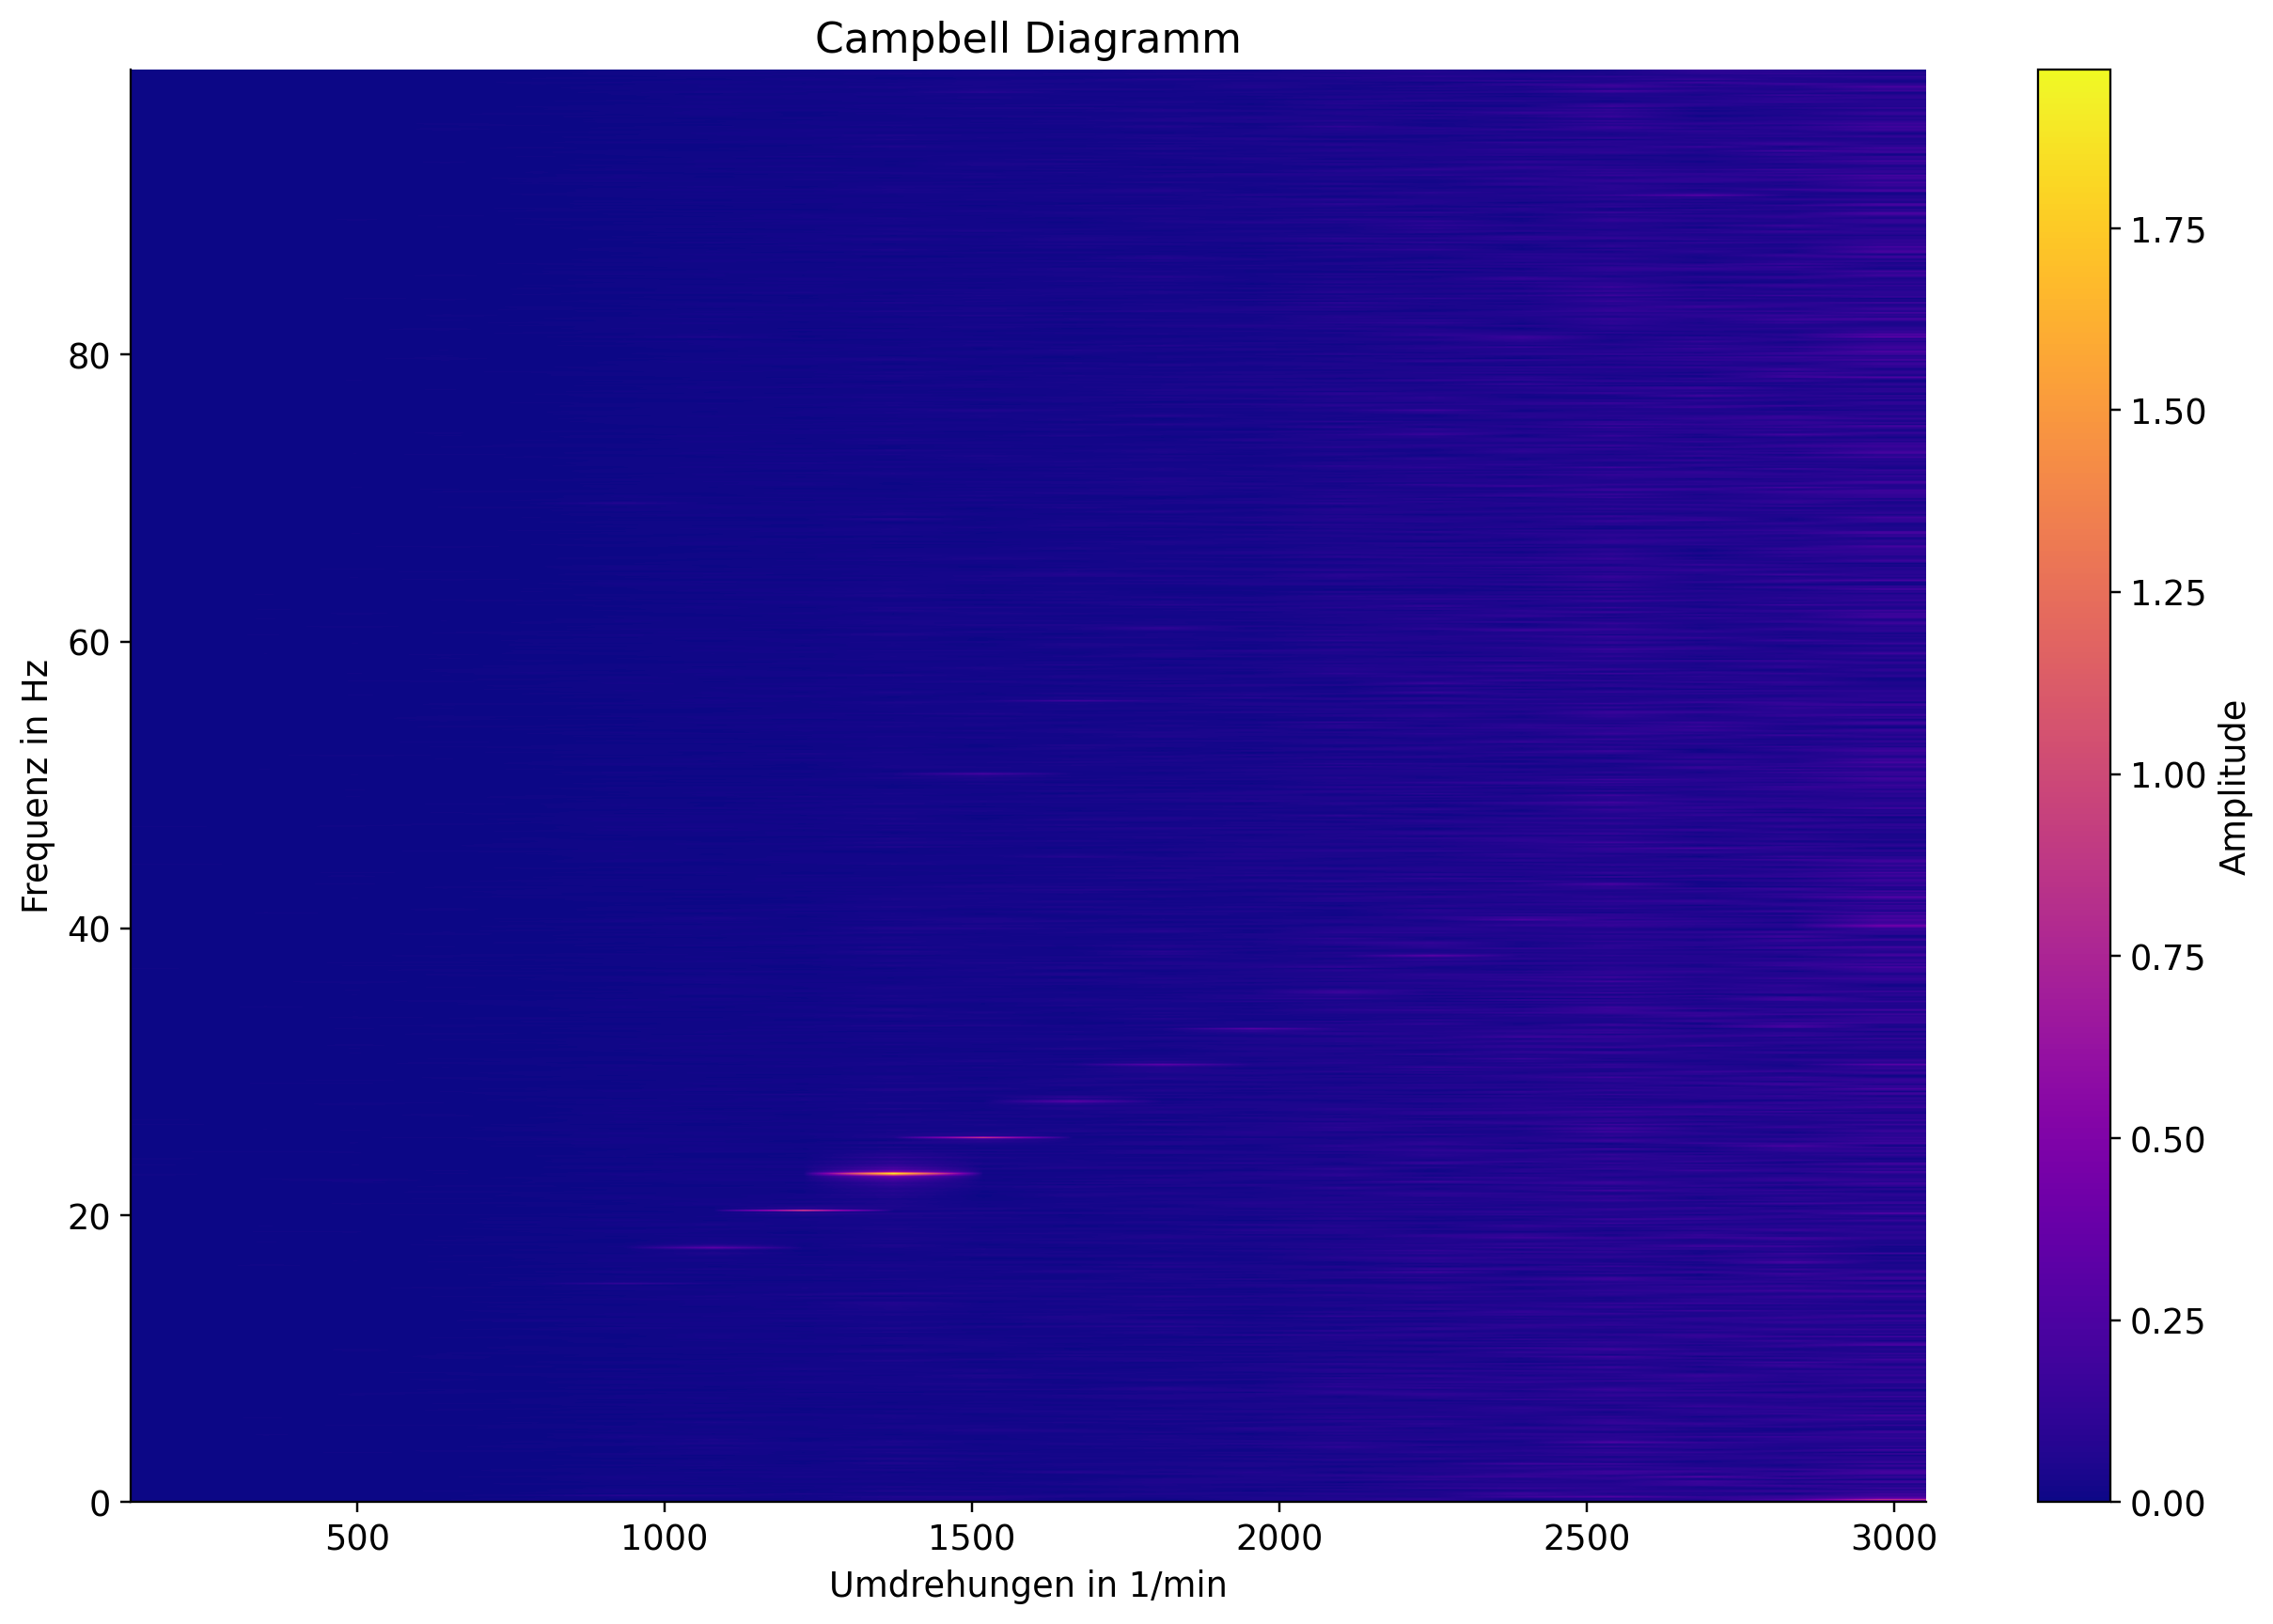

In [12]:
 import matplotlib.pyplot as plt

plt.figure(figsize=(14, 9))  


plt.imshow(amp_res, 
           extent=[min(rpm), 
                   max(rpm), 0, 
                   max(freq_ex)],  
           aspect="auto",  
           interpolation="bilinear",
           cmap="plasma",
           origin="lower"  
          )

plt.xlabel("Umdrehungen in 1/min")
plt.ylabel("Frequenz in Hz") 
plt.colorbar(label="Amplitude")
plt.title("Campbell Diagramm")
plt.show()

## Diskussion
Diskutieren Sie die Ergebnisse Ihrer Experimente aus wissenschaftlicher Sicht, gehen Sie dabei insbesondere auch auf die zu Beginn aufgestellte Forschungsfrage ein. Beispielsweise können Sie hier auf Einschränkungen der Aussagekraft der Ergebnisse eingehen.

Prüfstand 04: kritische Drehzahl bei ca.

$$
\omega_{krit} = 750 \frac{U}{min},
$$

Prüfstand 02: kritische Drehzahlen bei ca. 
$$
\omega_{krit,1} = 1000 \frac{U}{min}, \omega_{krit,2} = 2600 \frac{U}{min},
$$
was auf den ersten Blick plausibel scheint, dass diese größer sind als die aus Datensatz 1, da die beiden Scheiben eine geringere Masse aufweisen und

$$
\omega_{krit} \propto \frac{1}{m^\frac{1}{2}}
$$
Dennoch sind auch hier an dem Campbell-Diagramm einige Nebenmaxima zu erkennen, was ebenfalls auf eine eher instabile Rotordynamik hindeutet.

Prüfstand 03: kritische Drehzahl bei knapp
$$
\omega_{krit} = 1500 \frac{U}{min},
$$
wobei einige Nebenmaxima auftauchen, jedoch deutlich begrenzter als in den anderen Datensätzen. Hier ist die rotordynamische Stabilität deutlich besser und die Amplitude lässt sich eindeutig abgrenzen.Auch wenn insgesamt die Stabilität nicht optimal war, lassen sich in Datensatz 1 und 3 eindeutige Amplituden aus den Diagrammen ablesen. Datensatz 1 und 2 führen, ohne weiteres Hintergrundwissen über den Versuchsaufbau, zu einem verfälschten Ergebnis, da die Diagramme relativ große Nebenmaxima aufweisen, die auf weitere Drehzahlen hindeuten, obwohl nur eine (Datensatz 1) bzw. zwei (Datensatz 2) existieren.Prinzipiell lassen sich die Selbstzentrierungen durch die abnehmenden Amplituden (erkennbar an der dunkler werdenden Farbe) nach Durchfahren der kritischen Drehzahl(en) der Rotoren erkennen.

##### Vergleich der gemessenen mit der analytisch berechneten kritischen Drehzahl
Sie können für den Vergleich, falls benötigt auch Code Cells einfügen.

<img src="figures/Berechnung_krit_Drehzahl.jpeg" width="800">

 Wie man der Rechnung entnehmen kann, liegt die ablesbare kritische Drehzahl (750 U/min) unseres Prüfstandes im Bereich der errechneten, was auf eine zuverlässige Messung deutet, wenn man das oben genannte Nebenmaximum vernachlässigt.

## Fazit
Ziehen Sie ein Fazit zum durchgeführten Versuch, gehen Sie dabei gerne auf Ihrer persönliche Meinung oder Ihre Lernziele ein.

Dank des Experiments im Labor konnte ich beobachten, wie sich die Resonanzfrequenz auf die Systeme auswirkt, und mit der Analyse der gewonnenen Daten und verschiedenen Berechnungen konnte ich mich dem durch die Resonanzfrequenz verursachten Phänomen intensiver nähern. Schließlich habe die Gelegenheit gehabt, das Arbeiten mit einem Campbell-Diagramm kennenzulernen. Dadurch konnte ich verstehen, wie man potenzielle Resonanzfälle anschaulich darstellt und erkennt.
